In [331]:
from colorsys import yiq_to_rgb
from random import Random

from rdkit.Chem import AllChem
from rdkit import Chem
from collections import deque
import py3Dmol
import math
import numpy as np
import os
import pandas as pd
import glob
import re

from scipy.stats import bootstrap


In [332]:
def xyz_to_array(xyz_file):
    #oth index is num atoms
    #ith index is ith atom ID
    with open(xyz_file, 'r', encoding= 'utf-8') as file:
        lines = file.readlines()

    num_atoms = int(lines[0].strip())
    coordinates = []
    coordinates.append(num_atoms)

    for line in lines[2:]:
        parts = line.split()
        x, y, z = map(float, parts[1:4])
        coordinates.append([x, y, z])
    return coordinates

def bfs_traversal(mol,startingID):
    visited = set()
    queue = deque([startingID])
    bfs_order = []
    while queue:
        atom_id = queue.popleft()
        if atom_id not in visited:
            visited.add(atom_id)
            bfs_order.append(atom_id)
        atom = mol.GetAtomWithIdx(atom_id)
        for neighbor in atom.GetNeighbors():
            if neighbor.GetIdx() not in visited:
                queue.append(neighbor.GetIdx())
                
    bfs_nitrogens = []
    for id in bfs_order:
        if mol.GetAtomWithIdx(id).GetSymbol() == 'N':
            bfs_nitrogens.append(id)
        
    return bfs_nitrogens

def sort_files(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', os.path.basename(s))]



class Peptide:

    peptide_registry ={} # each peptide will store itself in the library

    def __init__(self, smiles_code, PercentCyclization, name, csv_of_properties):
        self.molecule = Chem.AddHs(Chem.MolFromSmiles(smiles_code))
        AllChem.EmbedMolecule(self.molecule)
        self.atom_IDs = [atom.GetIdx() for atom in self.molecule.GetAtoms()]
        self.conformers = []
        self.amideGroups = []
        self.PercentCyclization = PercentCyclization
        self.Name = name
        self.properties = pd.read_csv(csv_of_properties).to_dict(orient="records")
        Peptide.peptide_registry[name] = self #the key is the name, the oobject is the peptide itself
        
    def getProperties(self):
        return self.properties

    def getName(self):
        return self.Name

    def getPercentCyclization(self):
        return self.PercentCyclization

    def csearch(self):
        pass # = Conformer(self, xyz)

    def addConformer(self, conformer):
        self.conformers.append(conformer)

    def getConformers(self):
        return self.conformers

    def addAmides(self):
        self.amideGroups = []
        group = Chem.MolFromSmarts('[C](=[O])-[N]')
        n_terminus =Chem.MolFromSmarts('[N;H2]')
        matches = self.molecule.GetSubstructMatches(group)
        n_terminus_match = self.molecule.GetSubstructMatch(n_terminus)
        n_terminus_id = n_terminus_match[0]
        bfs_order = bfs_traversal(self.molecule,n_terminus_id)
        i= 1
        for nID in bfs_order:
            for match in matches:
                if nID in match:
                    self.amideGroups.append(AmideGroup(match,i,self))
                    i+=1
                    
                
        return "Added " + str(len(matches)) + " Amide groups to GroupIDs."


class Conformer(Peptide):
    def __init__(self, parent_peptide: Peptide, xyz_file, relative_energy):
        self.atom_coordinates = xyz_to_array(xyz_file)
        self.relative_energy = relative_energy
        self.parent_peptide = parent_peptide

    def getAmideDistances(self):
        distance_matrix = [[0.0 for _ in range(len(self.parent_peptide.amideGroups))] for _ in range(len(self.parent_peptide.amideGroups))]
        for i,amid1 in enumerate(self.parent_peptide.amideGroups):
            for j,amid2 in enumerate(self.parent_peptide.amideGroups):
                if i == j and amid1.getH() is not None:
                    distance_matrix[i][j] = 0.0
                else:
                    amid1H = amid1.getH()
                    if amid1H is None:
                        distance_matrix[i][j] = -1.0 #prolines have no nitrogen Hydrogen, so the distance is non existant
                    else:
                        amid2O = amid2.getO()
                        amid1H_pos = self.atom_coordinates[amid1H]
                        amid2O_pos = self.atom_coordinates[amid2O]
                        distance = ((amid1H_pos[0] - amid2O_pos[0])**2 + (amid1H_pos[1] - amid2O_pos[1])**2 + (amid1H_pos[2] - amid2O_pos[2])**2)**0.5
                        distance_matrix[i][j] = distance
        return distance_matrix




class AmideGroup:

    def __init__(self, atom_IDs, group_num, Peptide):
        self.group_num = group_num
        self.atom_IDs = atom_IDs
        self.C = self.atom_IDs[0]
        self.O = self.atom_IDs[1]
        self.N = self.atom_IDs[2]

        nitrogen = Peptide.molecule.GetAtomWithIdx(self.N)
        neighbors = nitrogen.GetNeighbors()
        hydrogen_id = None

        for neighbor in neighbors:
            if neighbor.GetSymbol() == 'H':
                hydrogen_id = neighbor.GetIdx()
                break
        self.H = hydrogen_id


    def getIDs(self):
        return self.atom_IDs
    def getC(self):
        return self.C
    def getO(self):
        return self.O
    def getN(self):
        return self.N
    def getH(self):
        return self.H
    def getGroupNum(self):
        return self.group_num


In [335]:
peptides = []
df = pd.read_csv("PeptideCyclizationSmiles.csv") #readas all peptide data
df = df[['Address','Smiles','Percent cyclization']].dropna() # drops other columns
peptide_data = df.set_index('Address').to_dict(orient="index") #makes data a dictionary accessible by the name of the peptide

#/Users/zaan/zasaeed@g.hmc.edu - Google Drive/My Drive/OMO Lab - Peptide Cyclization - Zaan Saeed/Data/Peptide Library
#/Users/zaansaeed/Google Drive/My Drive/OMO Lab - Peptide Cyclization - Zaan Saeed/Data/Peptide Library
for folder_name in os.listdir("/Users/zaansaeed/Google Drive/My Drive/OMO Lab - Peptide Cyclization - Zaan Saeed/Data/Peptide Library"):
    if folder_name.endswith("XYZ"):
        files = sorted(glob.glob(f"{"/Users/zaansaeed/Google Drive/My Drive/OMO Lab - Peptide Cyclization - Zaan Saeed/Data/Peptide Library/" + folder_name}/**/*",recursive=True),key=sort_files)
        peptide_name = folder_name[:4]
        peptide_csv = files[0]
        print(folder_name)
    
    
        if peptide_name in peptide_data.keys():
            smiles = peptide_data[peptide_name]['Smiles']
            percent = peptide_data[peptide_name]['Percent cyclization']
            peptide = Peptide(smiles, percent, peptide_name,peptide_csv)
            for i,file in enumerate(files):

                if file.endswith(".xyz"):
                    peptide.addConformer(Conformer(peptide, os.path.abspath(file),peptide.getProperties()[i-1]['Potential Energy-OPLS-2005'])) # adds a conformer where the energy for this conformer is at i-1 in the list since i is actually i+1 because the 0th index in files is the csv
    
            peptides.append(peptide)




R7C5_XYZ
R1C2_XYZ
R5C4_XYZ
R3C2_XYZ
R1C1_XYZ
R3C3_XYZ
R5C5_XYZ
R1C4_XYZ
R3C6_XYZ
R5C2_XYZ
R1C6_XYZ
R5C3_XYZ
R2C2_XYZ
R6C6_XYZ
R8C8_XYZ
R6C7_XYZ
R4C5_XYZ
R2C1_XYZ
R4C7_XYZ
R6C5_XYZ
R6C4_XYZ
R6C1_XYZ
R4C3_XYZ
R4C1_XYZ
R6C3_XYZ
R6C2_XYZ
R8C1_XYZ
R2C8_XYZ
R8C3_XYZ
R8C2_XYZ
R8C6_XYZ
R8C7_XYZ
R6C8_XYZ
R4C8_XYZ
R8C5_XYZ
R8C4_XYZ
R3C8_XYZ
R5C8_XYZ


In [336]:
def boltzmann(values, properties_of_each_conformer):
    numerator = 0
    denominator = 0
    boltzmann_results = []
    new_array = []
    for amide_array in range(len(values)):
        new_array = []
        for amide_row in range(len(values[0])):
            new_row =[]
            for amide_col in range(len(values[0][0])):
                e_term = 0
                denominator = 0
                numerator = 0
                answer = 0
                for k in range(len(properties_of_each_conformer)):
                    e_term = math.exp(-(properties_of_each_conformer[k]['Potential Energy-OPLS-2005'])/(298*8.314 * 10**-3))
                    denominator += e_term
                    
                    numerator += e_term * values[k][amide_row][amide_col]
                    answer = numerator/denominator
                new_row.append(answer)
            new_array.append(new_row)
    boltzmann_results.append(new_array)
            
    return boltzmann_results            
                
                



boltzmann_amide_distances = {}

for peptide in peptides:
    peptide.addAmides()
    amide_distances_of_all_conformers = []
    for conformer in peptide.getConformers():
        amide_distances_of_all_conformers.append(conformer.getAmideDistances())
        
    boltzmann_amide_distances[peptide.getName()] = boltzmann(amide_distances_of_all_conformers, peptide.getProperties())
        
        
        
    


In [337]:
def pad2DArray(array, max): #assumes that array is a square, and is being extended to be max * max size
    for i in array:
        for j in i:
            while(len(j)<max):
                j.append(0.0)
        while(len(i)<max):
            i.append([0]*max)
    return array


In [338]:
X = []
Y = []
for name, distance_matrix in boltzmann_amide_distances.items():
    X.append(pad2DArray(distance_matrix,7))
    if (Peptide.peptide_registry[name].getPercentCyclization()>90):
        Y.append(1)
    else:
        Y.append(0)

#    elif(Peptide.peptide_registry[name].getPercentCyclization()>80 and Peptide.peptide_registry[name].getPercentCyclization()<=96.5):
  #      Y.append(1)


In [339]:
X = np.array(X)
X = X.reshape(len(X), -1)
Y = np.array(Y)



In [342]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


# Splitting data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

param_grid = {
    'n_estimators': [200, 300,400],  # Number of trees in the forest
    'max_depth': [None, 10, 15, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 3,4,5, 10],  # Minimum number of samples to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}
model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=4,verbose=2, scoring='f1_weighted')
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)



Fitting 4 folds for each of 900 candidates, totalling 3600 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_esti

In [345]:
y_pred=grid_search.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy: ",accuracy )
print(classification_report(Y_test,y_pred))

Accuracy:  0.6875
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.64      1.00      0.78         9

    accuracy                           0.69        16
   macro avg       0.82      0.64      0.61        16
weighted avg       0.80      0.69      0.63        16



In [321]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, y_pred)
print(confusion_matrix)

[[3 4]
 [2 6]]


In [322]:
import matplotlib.pyplot as plt
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]



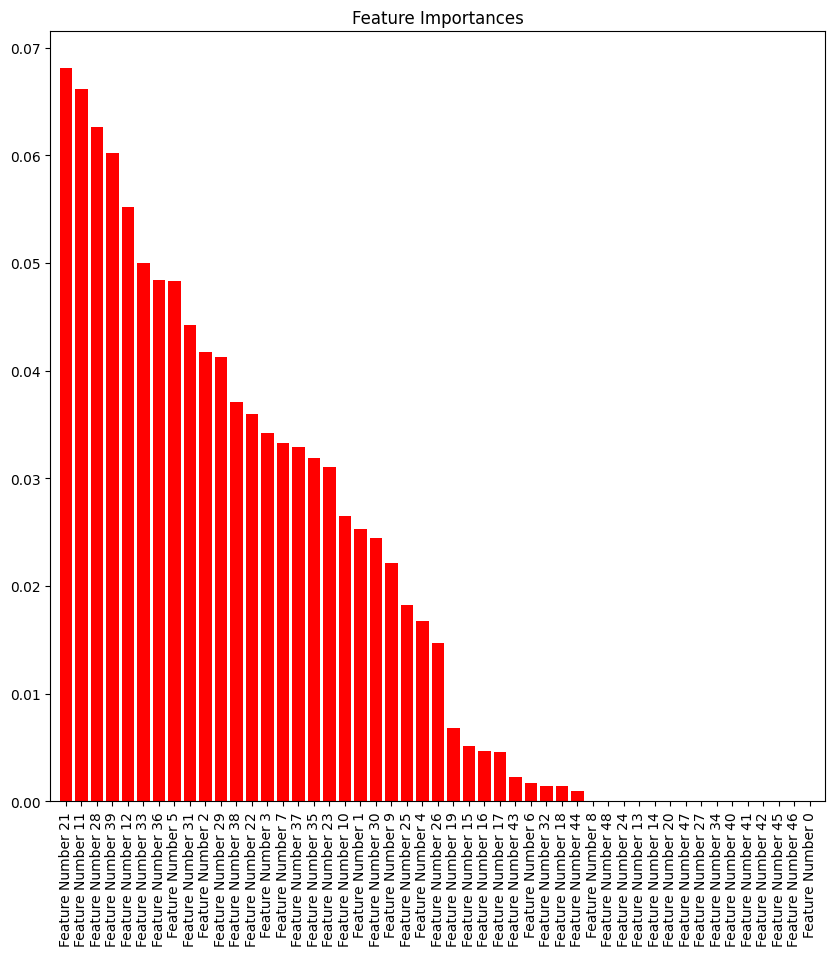

In [323]:
plt.figure(figsize=(10,10))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [f"Feature Number {i}" for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()